# Reads assignemnt 3D

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tifffile import imread, imwrite
from skimage.measure import regionprops
from tqdm.notebook import tqdm
from anndata import AnnData


## Load the tile config

In [2]:
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
image_path = os.path.join(base_path, 'images')
signal_path = os.path.join(base_path, 'signal')
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
if not os.path.exists(expr_path):
    os.mkdir(expr_path)

morph_path = os.path.join(image_path, 'morph')
if not os.path.exists(morph_path):
    os.mkdir(morph_path)

In [85]:
current_sample = 'sample6'
current_tile_xml = os.path.join(image_path, "fused/3D", current_sample, 'DAPI', 'dataset.xml')

In [86]:
setup_df = pd.read_xml(current_tile_xml, xpath=".//ViewRegistration")
setup_max = setup_df['setup'].max()
setup_max

424

In [87]:
setup_list = []
for i in range(setup_max+1):
    setup_list.append([i] * 3)
setup_list = np.array(setup_list).flatten()
setup_list

array([  0,   0,   0, ..., 424, 424, 424])

In [88]:
transform_df = pd.read_xml(current_tile_xml, xpath=".//ViewTransform")
transform_df['setup'] = setup_list
transform_df = transform_df.pivot(index='setup', columns='Name', values='affine')
transform_df = transform_df.loc[:, ["Stitching Transform", "Translation to Regular Grid"]]
transform_df['x_st'] = transform_df["Stitching Transform"].str.split(' ').apply(lambda x: x[3]).astype(float)
transform_df['y_st'] = transform_df["Stitching Transform"].str.split(' ').apply(lambda x: x[7]).astype(float)
transform_df['z_st'] = transform_df["Stitching Transform"].str.split(' ').apply(lambda x: x[11]).astype(float)

transform_df['x_trg'] = transform_df["Translation to Regular Grid"].str.split(' ').apply(lambda x: x[3]).astype(float)
transform_df['y_trg'] = transform_df["Translation to Regular Grid"].str.split(' ').apply(lambda x: x[7]).astype(float)
transform_df['z_trg'] = transform_df["Translation to Regular Grid"].str.split(' ').apply(lambda x: x[11]).astype(float)

transform_df['x'] = transform_df['x_st'] + transform_df['x_trg']
transform_df['y'] = transform_df['y_st'] + transform_df['y_trg']
transform_df['z'] = transform_df['z_st'] + transform_df['z_trg']

transform_df['x'] = transform_df['x'].astype(int)
transform_df['y'] = transform_df['y'].astype(int)
transform_df['z'] = transform_df['z'].astype(int)

transform_df['x'] = transform_df['x'] + np.abs(transform_df['x'].min())
transform_df['y'] = transform_df['y'] + np.abs(transform_df['y'].min())
transform_df['z'] = transform_df['z'] + np.abs(transform_df['z'].min())
transform_df['fov_index'] = transform_df.index

transform_df = transform_df.loc[:, ['x', 'y', 'z', 'fov_index']]

In [89]:
transform_df

Name,x,y,z,fov_index
setup,,,,
0,2,1,28,0
1,0,1344,28,1
2,1,2693,27,2
3,2,4035,26,3
4,2,5383,25,4
...,...,...,...,...
420,32491,16177,24,420
421,32491,17525,3,421
422,32491,18868,18,422


In [90]:
grid_file = os.path.join(image_path, "fused/3D", current_sample, 'grid.csv')
grid_df = pd.read_csv(grid_file, index_col=0)
grid_df

,col,row,id,grid
0,0,0,1524,tile_0_0
1,0,1,1519,tile_1_0
2,0,2,1510,tile_2_0
3,0,3,1497,tile_3_0
4,0,4,1480,tile_4_0
...,...,...,...,...
420,24,12,1299,tile_12_24
421,24,13,1290,tile_13_24
422,24,14,1283,tile_14_24
423,24,15,1278,tile_15_24


In [91]:
tile_config_df = pd.concat([transform_df, grid_df], axis=1)
tile_config_df

,x,y,z,fov_index,col,row,id,grid
0,2,1,28,0,0,0,1524,tile_0_0
1,0,1344,28,1,0,1,1519,tile_1_0
2,1,2693,27,2,0,2,1510,tile_2_0
3,2,4035,26,3,0,3,1497,tile_3_0
4,2,5383,25,4,0,4,1480,tile_4_0
...,...,...,...,...,...,...,...,...
420,32491,16177,24,420,24,12,1299,tile_12_24
421,32491,17525,3,421,24,13,1290,tile_13_24
422,32491,18868,18,422,24,14,1283,tile_14_24
423,32491,20219,2,423,24,15,1278,tile_15_24


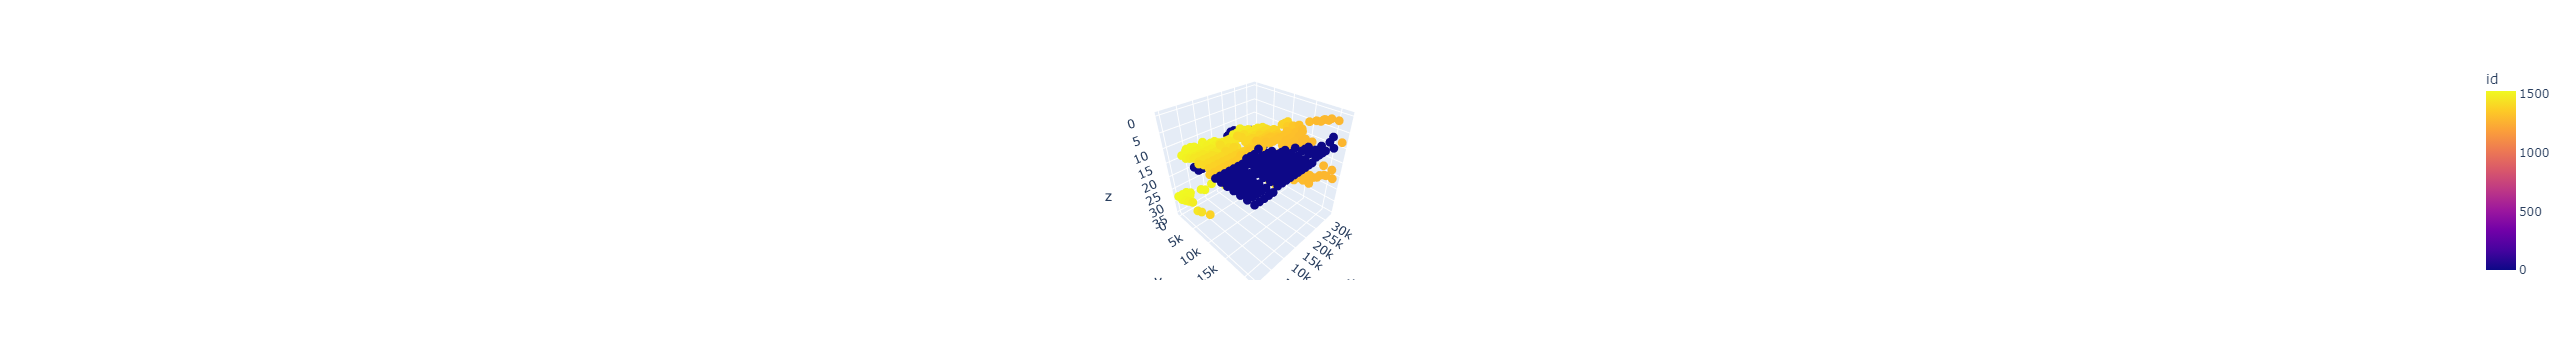

In [92]:
import plotly.express as px
fig = px.scatter_3d(tile_config_df, x='x', y='y', z='z', color='id')
fig.update_traces(marker_size = 5)
fig.update_scenes(zaxis_autorange="reversed")
# fig.update_scenes(yaxis_autorange="reversed")
fig.update_scenes(xaxis_autorange="reversed")
fig.show()
fig.write_html(os.path.join(output_path, f'tile_config_{current_sample}.html'))

In [93]:
img_dim = [1496, 1496, 35]
start_x_list = []
start_y_list = []
end_x_list = []
end_y_list = []

for i in tqdm(range(tile_config_df.shape[0])):
# for i in tqdm(range(7)):
    current_record = tile_config_df.iloc[i]
    current_id = current_record['id']

    if current_id == 0:
        start_x_list.append(0)
        start_y_list.append(0)
        end_x_list.append(0)
        end_y_list.append(0)
    else:
        print(f"Processing tile {current_id}")
        current_row = current_record['row']
        current_col = current_record['col']
        current_x = current_record['x']
        current_y = current_record['y']

        left_tile = f"tile_{current_row}_{current_col - 1}"
        right_tile = f"tile_{current_row}_{current_col + 1}"
        up_tile = f"tile_{current_row - 1}_{current_col}"
        down_tile = f"tile_{current_row + 1}_{current_col}"

        if left_tile in tile_config_df.grid.values and tile_config_df.loc[tile_config_df.grid == left_tile, 'id'].values != 0:
            left_x = tile_config_df.loc[tile_config_df.grid == left_tile, 'x'].values
            me_start_x = int((left_x + img_dim[0] - current_x)/2 + 0.5) + current_x
        else:
            me_start_x = current_x

        if up_tile in tile_config_df.grid.values and tile_config_df.loc[tile_config_df.grid == up_tile, 'id'].values != 0:
            left_y = tile_config_df.loc[tile_config_df.grid == up_tile, 'y'].values
            me_start_y = int((left_y + img_dim[1] - current_y)/2 + 0.5) + current_y
        else:
            me_start_y = current_y

        if right_tile in tile_config_df.grid.values and tile_config_df.loc[tile_config_df.grid == right_tile, 'id'].values != 0:
            right_x = tile_config_df.loc[tile_config_df.grid == right_tile, 'x'].values
            me_end_x = int((current_x + img_dim[0] - right_x)/2 + 0.5 + right_x)
        else:
            me_end_x =  current_x + img_dim[0]
            
        if down_tile in tile_config_df.grid.values and tile_config_df.loc[tile_config_df.grid == down_tile, 'id'].values != 0:
            right_y = tile_config_df.loc[tile_config_df.grid == down_tile, 'y'].values
            me_end_y = int((current_y + img_dim[0] - right_y)/2 + 0.5 + right_y)
        else:
            me_end_y = current_y + img_dim[0]

        current_start_point = [me_start_x, me_start_y]
        current_end_point = [me_end_x, me_end_y]
        start_x_list.append(me_start_x)
        start_y_list.append(me_start_y)
        end_x_list.append(me_end_x)
        end_y_list.append(me_end_y)


  0%|          | 0/425 [00:00<?, ?it/s]

Processing tile 1524
Processing tile 1519
Processing tile 1510
Processing tile 1497
Processing tile 1480
Processing tile 1459
Processing tile 1434
Processing tile 1409
Processing tile 1384
Processing tile 1359
Processing tile 1523
Processing tile 1518
Processing tile 1509
Processing tile 1496
Processing tile 1479
Processing tile 1458
Processing tile 1433
Processing tile 1408
Processing tile 1383
Processing tile 1358
Processing tile 1522
Processing tile 1517
Processing tile 1508
Processing tile 1495
Processing tile 1478
Processing tile 1457
Processing tile 1432
Processing tile 1407
Processing tile 1382
Processing tile 1357
Processing tile 1521
Processing tile 1516
Processing tile 1507
Processing tile 1494
Processing tile 1477
Processing tile 1456
Processing tile 1431
Processing tile 1406
Processing tile 1381
Processing tile 1356
Processing tile 1520
Processing tile 1515
Processing tile 1506
Processing tile 1493
Processing tile 1476
Processing tile 1455
Processing tile 1430
Processing ti

In [94]:
tile_config_df['start_x'] = start_x_list
tile_config_df['start_y'] = start_y_list
tile_config_df['end_x'] = end_x_list    
tile_config_df['end_y'] = end_y_list


In [95]:
tile_config_df['start_x_norm'] = tile_config_df['start_x'] - tile_config_df['x']
tile_config_df['start_y_norm'] = tile_config_df['start_y'] - tile_config_df['y']
tile_config_df['end_x_norm'] = tile_config_df['end_x'] - tile_config_df['x']
tile_config_df['end_y_norm'] = tile_config_df['end_y'] - tile_config_df['y']


In [96]:
tile_config_df.loc[tile_config_df.id == 0, 'start_x_norm'] = 0
tile_config_df.loc[tile_config_df.id == 0, 'start_y_norm'] = 0
tile_config_df.loc[tile_config_df.id == 0, 'end_x_norm'] = 0
tile_config_df.loc[tile_config_df.id == 0, 'end_y_norm'] = 0

In [97]:
tile_config_df.head(50)

,x,y,z,fov_index,col,row,id,grid,start_x,start_y,end_x,end_y,start_x_norm,start_y_norm,end_x_norm,end_y_norm
0,2,1,28,0,0,0,1524,tile_0_0,2,1,1426,1421,0,0,1424,1420
1,0,1344,28,1,0,1,1519,tile_1_0,0,1421,1425,2767,0,77,1425,1423
2,1,2693,27,2,0,2,1510,tile_2_0,1,2767,1426,4112,0,74,1425,1419
3,2,4035,26,3,0,3,1497,tile_3_0,2,4112,1426,5457,0,77,1424,1422
4,2,5383,25,4,0,4,1480,tile_4_0,2,5457,1427,6804,0,74,1425,1421
5,2,6729,27,5,0,5,1459,tile_5_0,2,6804,1427,8151,0,75,1425,1422
6,2,8077,26,6,0,6,1434,tile_6_0,2,8151,1427,9497,0,74,1425,1420
7,2,9420,8,7,0,7,1409,tile_7_0,2,9497,1428,10843,0,77,1426,1423
8,1,10769,24,8,0,8,1384,tile_8_0,1,10843,1427,12192,0,74,1426,1423
9,1,12119,9,9,0,9,1359,tile_9_0,1,12192,1427,13615,0,73,1426,1496


In [98]:
tile_config_df.to_csv(os.path.join(output_path, f'tile_config_{current_sample}.csv'))

In [99]:
for i in range(tile_config_df.shape[0]):
    current_record = tile_config_df.iloc[i]
    current_id = current_record['id']
    
    if current_id == 0:
        continue
    else:
        print(current_id)
        current_fov_id = f"Position{current_id:03}"

        # Create path 
        current_morph_path = os.path.join(morph_path, current_fov_id)
        if not os.path.exists(current_morph_path):
            os.mkdir(current_morph_path)

        current_expr_path = os.path.join(expr_path, current_fov_id)
        if not os.path.exists(current_expr_path):
            os.mkdir(current_expr_path)

        # Load images
        current_gray_img = imread(os.path.join(image_path, "flamingo", 'DAPI', f"{current_fov_id}.tif"))
        current_gray_max = np.max((current_gray_img), axis=0)
        current_label_img = imread(os.path.join(image_path, "flamingo", 'stardist_segmentation', f"{current_fov_id}.tif"))
        current_label_max = np.max((current_label_img > 0), axis=0)
        current_seg_coverage = (current_label_img > 0).sum() / (current_gray_img > 40).sum() * 100
        print(current_seg_coverage)

        # Load signal
        reads_df = pd.read_csv(os.path.join(signal_path, f'{current_fov_id}_goodSpots.csv'))
        reads_df['x'] = reads_df['x'] - 1
        reads_df['y'] = reads_df['y'] - 1
        reads_df['z'] = reads_df['z'] - 1
        reads_df['global_x'] = reads_df['x'] + current_record['x']
        reads_df['global_y'] = reads_df['y'] + current_record['y']
        reads_df['global_z'] = reads_df['z'] + current_record['z']

        # Load genes.csv
        genes_df = pd.read_csv(os.path.join(base_path, "genes.csv"), header=None)
        genes_df.columns = ['gene', 'barcode']

        # Reads assignment to cell
        points = reads_df.loc[:, ["x", "y", "z"]].values
        bases = reads_df['gene'].values
        reads_assignment = current_label_img[points[:, 2], points[:, 1], points[:, 0]]
        reads_df['seg_label'] = reads_assignment
        
        cell_locs = []
        total_cells = len(np.unique(current_label_img)) - 1
        areas = []
        seg_labels = []

        genes = genes_df['gene'].values
        cell_by_gene = np.zeros((total_cells, len(genes)))
        gene_seq_to_index = {}  # map from sequence to index into matrix

        for i, k in enumerate(genes):
            gene_seq_to_index[k] = i
            
        # Iterate through cells
        print('Iterate cells...')
        for i, region in enumerate(tqdm(regionprops(current_label_img, current_gray_img))):
            areas.append(region.area)
            cell_locs.append(region.centroid)
            seg_labels.append(region.label)
            current_cell_label = region.image
            current_cell_image = region.image_intensity
            imwrite(os.path.join(current_morph_path, f"mask_{region.label}.tif"), current_cell_label)
            imwrite(os.path.join(current_morph_path, f"img_{region.label}.tif"), current_cell_image)

            assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
            for j in assigned_reads:
                if j in gene_seq_to_index:
                    cell_by_gene[i, gene_seq_to_index[j]] += 1
            
        cell_locs = np.array(cell_locs).astype(int)
        global_cell_locs = cell_locs + np.array([current_record['z'], current_record['y'], current_record['x']])
        current_meta = pd.DataFrame({'sample': current_sample, 'fov_id': current_fov_id, 'volume': areas, 'fov_x': cell_locs[:, 2], 'fov_y': cell_locs[:, 1], 'fov_z': cell_locs[:, 0], 'seg_label': seg_labels,
                                    'global_x': global_cell_locs[:, 2], 'global_y': global_cell_locs[:, 1], 'global_z': global_cell_locs[:, 0]})
        cell_barcode_names = pd.DataFrame({'gene': genes})
        cell_barcode_names.index = cell_barcode_names['gene']

        # Create scanpy object
        adata = AnnData(X=cell_by_gene, obs=current_meta, var=cell_barcode_names)

        # Filter cells based on location 
        adata = adata[adata.obs['fov_x'].isin(range(current_record['start_x_norm'], current_record['end_x_norm'])), ]
        adata = adata[adata.obs['fov_y'].isin(range(current_record['start_y_norm'], current_record['end_y_norm'])), ]
        adata.obs = adata.obs.reset_index(drop=True)
        
        # Visualize the data
        # cell centers on the segmentation
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(current_label_max, cmap='gray')
        rect = patches.Rectangle((current_record.start_x_norm, current_record.start_y_norm), 
                                current_record.end_x_norm - current_record.start_x_norm, 
                                current_record.end_y_norm - current_record.start_y_norm,
                                linewidth=.5, edgecolor='y', facecolor='none')
        ax.add_patch(rect)

        ax.plot(current_meta.fov_x, current_meta.fov_y, 'k.', markersize=1, )
        ax.plot(adata.obs.fov_x, adata.obs.fov_y, 'r.', markersize=2, ) 
        plt.savefig(os.path.join(current_expr_path, f"cell_centers_on_label.png"))
        plt.clf()
        plt.close()
        # plt.show()

        # cell centers on the dapi
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(current_gray_max, cmap='gray')
        rect = patches.Rectangle((current_record.start_x_norm, current_record.start_y_norm), 
                                current_record.end_x_norm - current_record.start_x_norm, 
                                current_record.end_y_norm - current_record.start_y_norm,
                                linewidth=.5, edgecolor='y', facecolor='none')
        ax.add_patch(rect)

        ax.plot(current_meta.fov_x, current_meta.fov_y, 'k.', markersize=1, )
        ax.plot(adata.obs.fov_x, adata.obs.fov_y, 'r.', markersize=2, ) 
        plt.savefig(os.path.join(current_expr_path, f"cell_centers_on_dapi.png"))
        plt.clf()
        plt.close()
        # plt.show()

        # reads on the segmentation
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(current_label_max, cmap='gray')
        rect = patches.Rectangle((current_record.start_x_norm, current_record.start_y_norm), 
                                current_record.end_x_norm - current_record.start_x_norm, 
                                current_record.end_y_norm - current_record.start_y_norm,
                                linewidth=.5, edgecolor='y', facecolor='none')
        ax.add_patch(rect)

        ax.plot(reads_df.x, reads_df.y, 'r.', markersize=1, )
        plt.savefig(os.path.join(current_expr_path, f"reads_on_label.png"))
        plt.clf()
        plt.close()
        # plt.show()

        # Output
        # log
        with open(os.path.join(current_expr_path, "log.txt"), 'w') as f:
            msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells\n".format(cell_by_gene.sum()/len(bases), cell_by_gene.sum(), len(bases), total_cells)
            f.write(msg)
            f.write(f"segmentation coverage: {current_seg_coverage:.2f}%")

        # adata
        adata.write(os.path.join(current_expr_path, "raw.h5ad"))
        
        # reads assignment
        reads_df.to_csv(os.path.join(current_expr_path, "reads_assignment.csv"), index=False)

        break


        

1524
81.44952646434092
Iterate cells...


  0%|          | 0/1802 [00:00<?, ?it/s]

/home/unix/jiahao/anaconda3/envs/starfinder/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning:

Transforming to str index.



In [132]:
with open("/home/unix/jiahao/wanglab/jiahao/Github/starfinder/test/Jiakun/fov.txt", "w") as f:
    for i in range(1, 1524 + 1):
        f.write(f"{str(i)}\n")